In [14]:
import subprocess
from rpy2.robjects import r
from rc_data_class import RcData
from rc_folds_class  import rcFolds
from rc_pred_ann_model import PredAnnModel
from rc_individual_fold import RcFoldForANN
import numpy as np
import random
import pandas as pd
import random
import matplotlib.pyplot as plt
import pickle

def get_genes_list(p_thresh, split_train):
    # Define the R script path
    r_script = "rc_get_diff_genes.r"
    
    # Build the command to run the R script
    command = ["Rscript", r_script, str(p_thresh), str(split_train)]
    
    result = subprocess.run(command, capture_output=True, text=True)
    
    # Check if the R script ran successfully
    if result.returncode == 0:
        print("R script executed successfully.")
    
        # Read the generated file
        rds_path = '/tmp/work/RCproject_code/sean_ann_python/ann_gene_set.rds'
        current_genes = r.readRDS(rds_path)
        print(len(current_genes))
        
    else:
        print("Error in R script execution:")
        print(result.stderr)

    return(current_genes.tolist())

def get_first_gen(n_pop,input_genes):
    first_gen = [];
    gene_list_length = len(input_genes)  # Length of the gene list
    for i in range(n_pop):
        binary_list = [random.choice([0, 1]) for _ in range(gene_list_length)]  # Create a binary list of the same length
        binary_array = np.array(binary_list)  # Convert binary list to a NumPy array
        first_gen.append(binary_array)

    return(first_gen)

def evaluate_individuals(input_gen,gene_list,folds,input_data,num_epochs):
    auc_averages = []
    current_folds = rcFolds(input_data,folds)
    current_gen_member = 1
    for gen_member in input_gen:
        filtered_list = np.array(gene_list)[gen_member == 1] # Use binary array to filter the genes list
        current_aucs = []
        for i in range(folds):
            current_fold = RcFoldForANN(current_folds,i)
            fold_count = i + 1
            print(f"Currently training, population member {current_gen_member}, with fold {fold_count}.")
            current_model = PredAnnModel(current_fold,current_genes, num_epochs = num_epochs)
            test_auc_list = current_model.test_auc_list
            current_auc = max(test_auc_list)
            current_aucs.append(current_auc)
        current_average_auc = np.mean(current_aucs)
        auc_averages.append(current_average_auc)
        current_gen_member += 1
    ga_df.loc[len(ga_df)] = auc_averages
    return auc_averages, input_gen

# Crossover function
def crossover_and_mutate(current_gen, current_aucs, mutation_rate):

    indices = np.argsort(current_aucs)[-2:][::-1]  # Sort, pick the last two, and reverse to get highest first
    parent1 = current_gen[indices[0]]
    parent2 = current_gen[indices[1]]
    
    # Ensure parents are the same size
    if len(parent1) != len(parent2):
        raise ValueError("Parents must have the same length.")

    # Randomly choose a crossover point
    crossover_point = random.randint(1, len(parent1) - 1)

    # Create children by combining parts of each parent
    child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child = bit_flip_mutation(child, mutation_rate)

    return child

def bit_flip_mutation(individual, mutation_rate=0.01):
    # Go through each gene in the individual
    for i in range(len(individual)):
        if random.random() < mutation_rate:  # If random number is below mutation rate, flip the gene
            individual[i] = 1 - individual[i]  # Flip 0 to 1, or 1 to 0
    return individual

def plot_row_averages(df):
    """
    Plots the average of each row in the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing numerical values.
    """
    row_averages = df.mean(axis=1)  # Compute the average across each row
    
    plt.figure(figsize=(10, 5))
    plt.plot(row_averages, marker='o', linestyle='-', color='b', label='Row Averages')
    
    plt.xlabel("Generation")
    plt.ylabel("Average AUC Values")
    plt.title("Average of Each Row in DataFrame")
    plt.legend()
    plt.grid(True)
    
    plt.show()
    
population_size = 5
p_value = 0.1
split_train = True
folds = 5
num_epochs = 50
mutation_rate = 0.05
n_generations = 50
dna_dict = {}  # Empty dictionary

# making a data frame to keep track of GA progress
column_names = [f'auc_{i+1}' for i in range(population_size)]
# Initialize an empty DataFrame with columns
ga_df = pd.DataFrame(columns=column_names)

current_data = RcData()
current_genes = get_genes_list(p_value, split_train)
first_gen = get_first_gen(population_size,current_genes)
print("Now entering generation #: 1")
current_aucs, current_gen = evaluate_individuals(first_gen,current_genes,folds,current_data,num_epochs)

for i in range(n_generations):
    current_gen_number = i + 2
    print(f"Now entering generation #: {current_gen_number}")
    new_gen = []
    for x in range(population_size):
        child = crossover_and_mutate(current_gen,current_aucs,mutation_rate)
        new_gen.append(child)
    dna_dict[current_gen_number] = new_gen
    current_gen = new_gen
    current_aucs, current_gen = evaluate_individuals(current_gen,current_genes,folds,current_data,num_epochs)
    pickle.dump(dna_dict, open("dna_dict.pkl", "wb"))
    ga_df.to_pickle("ga_df.pkl")

Data successfully loaded.
R script executed successfully.
910
Now entering generation #: 1
Currently training, population member 1, with fold 1.
Epoch 0, Average Outcome Loss: 0.69707633389367, Average Accuracy: 0.4513888888888889, Test AUC: 0.5000, Test Accuracy: 0.6622
Currently training, population member 1, with fold 2.
Epoch 0, Average Outcome Loss: 0.7596586147944132, Average Accuracy: 0.5, Test AUC: 0.5000, Test Accuracy: 0.6486
Currently training, population member 1, with fold 3.
Epoch 0, Average Outcome Loss: 0.7364831897947524, Average Accuracy: 0.4930555555555556, Test AUC: 0.5000, Test Accuracy: 0.3514
Currently training, population member 1, with fold 4.
Epoch 0, Average Outcome Loss: 0.6964207887649536, Average Accuracy: 0.4791666666666667, Test AUC: 0.5000, Test Accuracy: 0.3514
Currently training, population member 1, with fold 5.
Epoch 0, Average Outcome Loss: 0.6825913919342889, Average Accuracy: 0.5972222222222222, Test AUC: 0.5000, Test Accuracy: 0.3425
Currently t

In [15]:
# Load the df back
loaded_df = pd.read_pickle("ga_df.pkl")

# Load the dictionary to select the sequences of interest
dna_dict = pickle.load(open("dna_dict.pkl", "rb"))

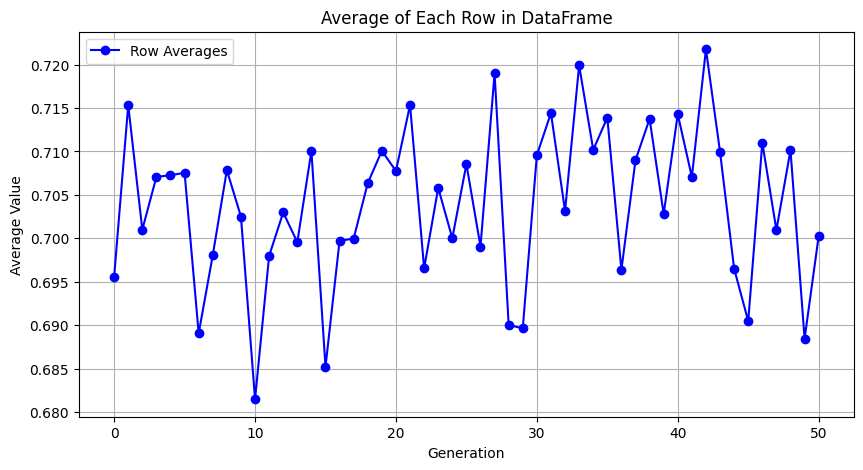

In [16]:
plot_row_averages(loaded_df)